In [76]:
%set_env SHELL=/bin/bash
%set_env OMP_NUM_THREADS=8
%set_env VECLIB_MAXIMUM_THREADS=1
%set_env ASE_CP2K_COMMAND=cp2k_shell.ssmp

env: SHELL=/bin/bash
env: OMP_NUM_THREADS=8
env: VECLIB_MAXIMUM_THREADS=1
env: ASE_CP2K_COMMAND=cp2k_shell.ssmp


In [77]:
# General
import os
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
from copy import deepcopy

# For building things
from ase import Atom, Atoms
from ase.io import read, write
from ase.io.trajectory import Trajectory
from ase.build import molecule, sort, add_adsorbate, surface
from ase.visualize import view
from ase.neighborlist import NeighborList, natural_cutoffs

# Unit Conversions and Fixing Atoms
from ase.units import Bohr,Rydberg,kJ,kB,fs,Hartree,mol,kcal
from ase.constraints import FixedPlane, FixedLine, FixAtoms

# ASE Calculators
from plumed import Plumed
from ase.calculators.cp2k import CP2K
from ase.calculators.lj import LennardJones
from ase.calculators.plumed import Plumed
from ase.calculators.idealgas import IdealGas

# Geometry Optimizations and Normal Mode Analysis
from ase.optimize import LBFGS, FIRE
from ase.vibrations import Vibrations
from ase.thermochemistry import IdealGasThermo

# EOS fitting for Unit Cells
from ase.eos import EquationOfState, calculate_eos

# Molecular Dynamics
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase.md.langevin import Langevin
from ase.md.npt import NPT

cwd = os.getcwd()

In [78]:
from mycalculators import *

In [79]:
bo4 = read("../../Resources/xyz/lignin/GG/BO4.xyz")
view(bo4, viewer = "ngl")

In [7]:
zeo = read("../../Resources/cif/zeolites/MWW.cif")
view(zeo, viewer="ngl")

# EOS for Zeolite

In [80]:
calc = CP2KCalculator(ecut=400, functional="rVV10", scf=20, orbital_transform=True, voronoi=True)

<AxesSubplot:title={'center':'\\bf sj: E: -70887.143 eV, V: 4550.336 Å$^3$, B: 141.023 GPa'}, xlabel='\\bf Volume (Å$^3$)', ylabel='\\bf Energy (eV)'>

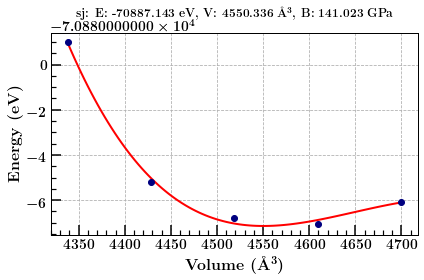

In [15]:
zeo.calc = calc

v0 = zeo.get_volume()
cell0 = zeo.get_cell()
    
start = time.time()
eos = calculate_eos(zeo,npoints=5, eps=0.04,trajectory="zeo-eos.traj")
v, e, B = eos.fit()  # find minimum
end = time.time()
elapsed = end - start

# Do one more calculation at the minimum and write to database:
s = (v/v0)**(1./3.)
zeo.set_cell(cell0*s, scale_atoms=True)
zeo.get_potential_energy()
write("zeo-optimized.xyz", zeo) 
B_GPa = B / kJ * 1.0e24
    
eos.plot(filename="zeo.png")

In [72]:
zeo.get_potential_energy()

-70887.030717182

In [83]:
rOH = 1.0
rSiO = 1.0

angleSiOH = np.deg2rad(109.5)
angleOSiO = np.deg2rad(109.5)

supercell = surface(supercell, indices=(0,0,1), layers=1, vacuum=10.0, tol=1e-10, periodic=True)

cutoffz = 0.5*np.sum(supercell.get_cell()[:,2])
#del supercell[[atom.index for atom in supercell if atom.position[2] < cutoffz]]
#supercell.center()
#view(supercell)

cuts = natural_cutoffs(supercell)
nl = NeighborList(cuts, self_interaction=False, bothways=True)
nl.update(supercell)

# Loop over all atoms
natoms = len(supercell)
for idx in range(0, natoms):

        # Get neighbors for atom i
        indices, offsets = nl.get_neighbors(idx)
        
        # If atom i is and Oxygen with only 1 neighbor, it needs H to satisfy its valency
        if supercell[idx].symbol == 'O' and len(indices) < 2:
                
                # Get corrdinates of Oxygen Atom
                terminal_O_xyz = supercell[idx].position

                # Get corrdinates of neighboring atoms
                for i, offset in zip(indices, offsets):
                    neighboring_Si_xyz = supercell.positions[i] + np.dot(offset, supercell.get_cell())

                    
                # Generate vector
                position_vector_Si_to_O = terminal_O_xyz - neighboring_Si_xyz

                
                # Use spherical coordinates to make coordinates for H atom
                if neighboring_Si_xyz[2] >= 0:
                    theta = 2.0*np.random.rand()*np.pi
                    terminal_H_x = rOH * np.cos(theta) * np.sin(angleSiOH) 
                    terminal_H_y = rOH * np.sin(theta) * np.sin(angleSiOH)
                    terminal_H_z = rOH * np.cos(angleSiOH)
                    terminal_H_x = neighboring_Si_xyz[0] + position_vector_Si_to_O[0] + terminal_H_x 
                    terminal_H_y = neighboring_Si_xyz[1] + position_vector_Si_to_O[1] + terminal_H_y 
                    terminal_H_z = neighboring_Si_xyz[2] + position_vector_Si_to_O[2] + terminal_H_z
                else:
                    theta = 2.0*np.random.rand()*np.pi
                    terminal_H_x = rOH * np.cos(theta) * np.sin(angleSiOH) 
                    terminal_H_y = rOH * np.sin(theta) * np.sin(angleSiOH)
                    terminal_H_z = rOH * np.cos(angleSiOH)
                    terminal_H_x = neighboring_Si_xyz[0] + position_vector_Si_to_O[0] - terminal_H_x 
                    terminal_H_y = neighboring_Si_xyz[1] + position_vector_Si_to_O[1] - terminal_H_y 
                    terminal_H_z = neighboring_Si_xyz[2] + position_vector_Si_to_O[2] - terminal_H_z

                Hatom = Atom('H', [terminal_H_x, terminal_H_y, terminal_H_z])

                supercell = supercell + Hatom
        
        # If atom i is Si with 3 neighbors, it needs OH to satisfy its valency
        if supercell[idx].symbol == 'Si' and len(indices) < 4:
            # Get corrdinates of Si Atom
            terminal_Si_xyz = supercell[idx].position

            # Get corrdinates of neighboring atoms
            neighbor_O_xyzs = []
            for i, offset in zip(indices, offsets):
                neighbor_O_xyzs.append(supercell.positions[i] + np.dot(offset, supercell.get_cell()))
                
            # Find the center of the circle made by the three oxygen atoms
            A = neighbor_O_xyzs[0]
            B = neighbor_O_xyzs[1]
            C = neighbor_O_xyzs[2]
            u1 = B - A
            w1 = np.cross(C-A, u1)
            
            u = u1 / np.linalg.norm(u1)
            w = w1 / np.linalg.norm(w1)
            v = np.cross(w,u)
            
            b = [np.dot(B-A,u), 0.0]
            c = [np.dot(C-A,u),np.dot(C-A,v)]
            
            h = ((c[0] - 0.5*b[0])**2 + c[1]**2 - (0.5*b[0])**2) / (2.0 * c[1])
            center = A + 0.5*b[0]*u + h*v
            
            # Generate vector
            vector_center_to_Si = terminal_Si_xyz - center
            unit_vector = vector_center_to_Si / np.linalg.norm(vector_center_to_Si)
            position_O = terminal_Si_xyz + rSiO*unit_vector
            
            Oatom =  Atoms('O', [position_O])
            
            vector_Si_to_O = position_O - terminal_Si_xyz
          
            # Use spherical coordinates to make coordinates for H atom
            theta = 2.0*np.random.rand()*np.pi
            terminal_H_x = rOH * np.cos(theta) * np.sin(angleSiOH) 
            terminal_H_y = rOH * np.sin(theta) * np.sin(angleSiOH)
            terminal_H_z = rOH * np.cos(angleSiOH)

            if terminal_Si_xyz[2] >= 0:
                terminal_H_x = terminal_Si_xyz[0] + vector_Si_to_O[0] - terminal_H_x 
                terminal_H_y = terminal_Si_xyz[1] + vector_Si_to_O[1] - terminal_H_y 
                terminal_H_z = terminal_Si_xyz[2] + vector_Si_to_O[2] - terminal_H_z
                
            else:
                terminal_H_x = terminal_Si_xyz[0] + vector_Si_to_O[0] + terminal_H_x 
                terminal_H_y = terminal_Si_xyz[1] + vector_Si_to_O[1] + terminal_H_y 
                terminal_H_z = terminal_Si_xyz[2] + vector_Si_to_O[2] + terminal_H_z

            Hatom = Atom('H', [terminal_H_x, terminal_H_y, terminal_H_z])
            
            OH = Oatom + Hatom 
            supercell = supercell + OH
            print()
                

supercell= sort(supercell, supercell.positions[:,2])

#Try to get two oxygen atoms in the middle of the framework
c = FixAtoms(indices=[len(supercell)//2, len(supercell)//2 + 1])
supercell.set_constraint(c)
supercell.calc = calc
view(supercell, viewer="ngl")

# Minimize the Nanosheet

In [85]:
minimizer = FIRE(supercell, trajectory="fire.traj", logfile="fire.log")
minimizer.run(fmax=0.03)
potentialenergy = supercell.get_potential_energy()

In [39]:
traj = Trajectory('fire.traj')
supercell = traj[-1]

In [40]:
view(supercell, viewer="ngl")

# Adding Bronsted Acidity

In [81]:
# Atom Indices of the Si atoms we want to substitute for Al, as well as the O atoms for the BA Site
T1 = 209
T4 = 185
T1_O = 201
T4_O = 191

In [82]:
def create_bronsted_acid_site(atoms, Si_index, O_index, rOH=1.0):
    
    # Make the Symbol for the Si_index Aluminum
    
    tmp = deepcopy(atoms)
    original_elements = tmp.get_chemical_symbols()
    
    original_elements[Si_index] = "Al"
    tmp.set_chemical_symbols(original_elements)
    
    # Get the coordinates of the Al atom and the Si atom next to the oxygen
    #r_Al = atoms.positions[Si_index]
    cuts = natural_cutoffs(tmp)
    nl = NeighborList(cuts, self_interaction=False, bothways=True)
    nl.update(tmp)
    
    # Get neighbors for atom i
    indices, offsets = nl.get_neighbors(O_index)
    
    # Get corrdinates of neighboring atoms
    neighbor_O_xyzs = []
    for i, offset in zip(indices, offsets):
        neighbor_O_xyzs.append(tmp.positions[i] + np.dot(offset, tmp.get_cell()))
    
    midpoint = 0.5*(neighbor_O_xyzs[0]+neighbor_O_xyzs[1])
    vector_midpoint_to_oxygen = tmp.positions[O_index] - midpoint
    unit_vector = vector_midpoint_to_oxygen / np.linalg.norm(vector_midpoint_to_oxygen)
    H_position = midpoint + vector_midpoint_to_oxygen + rOH*unit_vector
    
    Hatom = Atom('H', H_position)
    return tmp + Hatom


In [50]:
supercell
supercell_T1 = create_bronsted_acid_site(supercell, T1, T1_O, rOH=1.0)
supercell_T4 = create_bronsted_acid_site(supercell, T4, T4_O, rOH=1.0)
supercell_T1T4 = create_bronsted_acid_site(supercell_T1, T4, T4_O, rOH=1.0)

In [92]:
def create_probe_on_zeo(zeolite, probe, height=1.5, nrepeats=(1,1,1)):

    system = zeolite.repeat(nrepeats)
    system = sort(system, system.positions[:,2])
    
    box = system.get_cell()
    x = 0.5*(box[0][0] + box[1][0] + box[2][0])
    y = 0.5*(box[0][1] + box[1][1] + box[2][1])
    
    # Get the center of mass of the probe
    r_com = probe.get_center_of_mass()
    
    # Find out how far the COM is from index 0
    delta = probe.positions[0] - r_com
    
    add_adsorbate(system, probe, height, position=(x+delta[0], y+delta[1]), offset=None, mol_index=0)
      
    return system

In [61]:
bo4_supercell = create_probe_on_zeo(supercell, bo4, nrepeats=(2,2,1))
view(bo4_supercell, viewer="ngl")

In [69]:
def set_tags(atoms, slablength, probelength):
    
    for i in range(0, slablength):
        atoms[i].tag = 0
        
    for i in range(slablength, probelength+slablength):
        atoms[i].tag = 1

def runMD(atoms, name, temp=298.0, runlength=40000):
    
    MaxwellBoltzmannDistribution(atoms, temperature_K=300)
    
    md = Langevin(atoms, 0.5*fs, temperature_K = temp, friction=0.01, 
              trajectory=name+"_langevin.traj", logfile=name+'_langevin.log')
    
    md.run(runlength)

In [93]:
bo4_supercell.calc = calc
set_tags(bo4_supercell, len(supercell.repeat((2,2,1))), len(bo4))

# Freeze two atoms in the middle of the zeolite
idx_1 = (len(supercell.repeat((2,2,1))) - len(bo4)) // 2
idx_2 = (len(supercell.repeat((2,2,1))) - len(bo4)) // 2 + 1

c = FixAtoms(indices=[idx_1, idx_2])
bo4_supercell.set_constraint(c)

In [94]:
view(bo4_supercell)

<Popen: returncode: None args: ['/home/woodrowwilson/Programs/miniconda3/bin...>

/home/woodrowwilson/Programs/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
runMD(bo4_supercell, name="pureSi", temp=450.0, runlength=2000)